Коррекция сферических расхождений с использованием скорости однократных отражений.

In [97]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.signal import medfilt, hilbert

sys.path.append('..')

from seismicpro.batchflow import Dataset
from seismicpro.src import (SeismicBatch, SegyFilesIndex, FieldIndex, TraceIndex,
                            seismic_plot, spectrum_plot, merge_segy_files, KNNIndex)

from utils import draw_gain

plt.style.use('ggplot')
path_raw = '/Users/anton/work/geolog/raw_data/2_Egor_TAR/P00_raw.sgy'

field_index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw))
field_index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw
FieldRecord,,,,
2020,549,285,1,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,-555,286,2,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,564,284,3,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,-583,287,4,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,600,283,5,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...


In [98]:
batch = (Dataset(field_index, SeismicBatch).next_batch(500)
         .load(fmt='segy', components='raw', tslice=slice(3000))
)

Будем смотреть как происходит коррекция сферических расхождений на кропе филда и на целом филде.

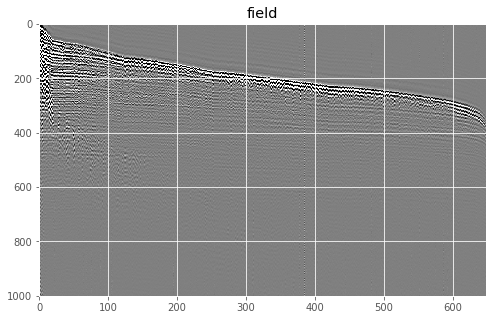

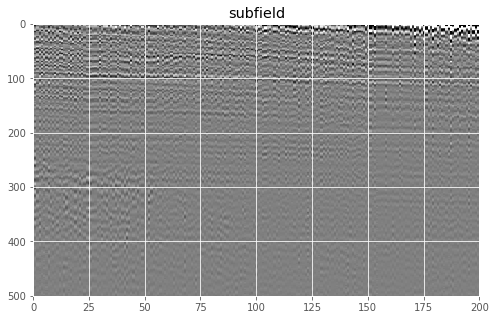

In [99]:
sample = batch.raw[21]

cv = .1
subsample = sample[100:300, 200:700]
seismic_plot(sample*10000, figsize=(8, 5), names='field',
             vmin=-cv, vmax=cv, cmap='gray', )
seismic_plot(subsample*10000, figsize=(8, 5), names='subfield',
             vmin=-cv, vmax=cv, cmap='gray')

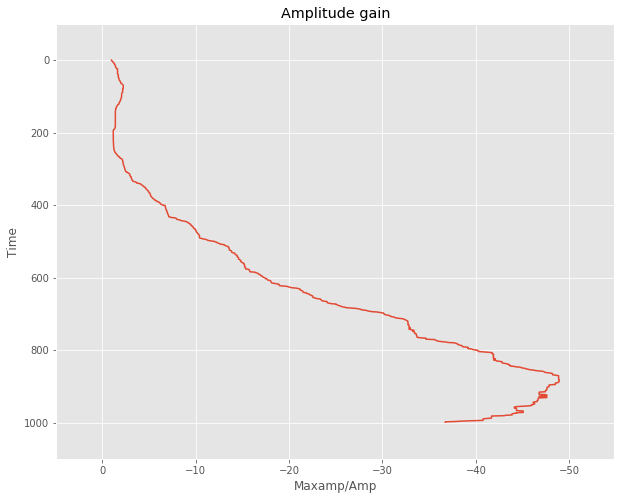

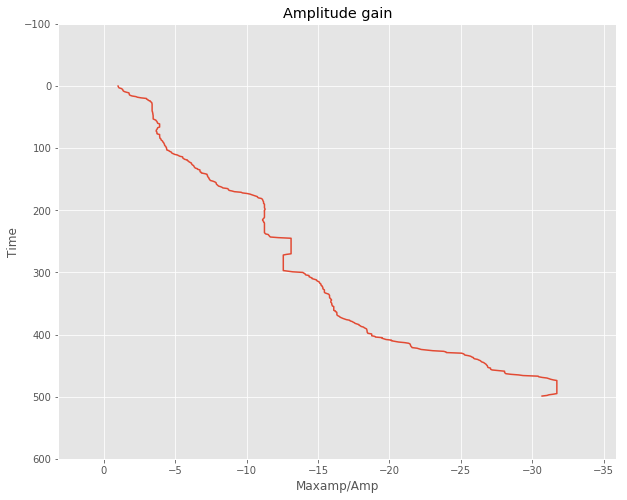

In [130]:
draw_gain(sample, 51)
draw_gain(subsample, 51)

Скорость берем из софта

In [4]:
speed = np.array([1524]*700 + [1924.5]*300 + [2184.0]*400 +  [2339.6]*400 + 
                 [2676]*150 + [2889.5]*2250 + [3566]*2800 + [4785.3]*1000)

Для коррекции сферических расхождений, значения амплитуд в контретное значение времени домножается на растущую функцию коррекции затухания $g(t)$.
$$A_{new}(t) = A(t) * g(t)$$
Для слоистого разреза затухание амплитуд может быть приблизительно описана следующей формулой:
$$g(t) = \frac{t^{pow_t} * V_{rms}^{pow_v}(t)}{V_0}$$
Где,
* $V_{rms}$ - среднеквадратическая скорость однократных отражений.
* $t$ - полное время пробега
* $V_0$ - начальное значение скорости.

$pow_t$ и $pow_v$ настраиваемые параметры.

In [180]:
def calc_v_rms(t, speed):
    if t == 0:
        return speed[0]
    return (np.mean(speed[:t]**2))**.5

def time_g(time, speed, t_pow, v_pow):
    correction = (calc_v_rms(time, speed) ** v_pow * time ** t_pow)/speed[0]
    if correction == 0:
        return 1.
    return correction

speed_sample = speed[:sample.shape[1]]
def time_dep(trace, speed, time, v_pow=2, t_pow=1):
    speed = speed[: trace.shape[1]]
    new_trace = np.zeros_like(trace)
    for ix, t in enumerate(time):
        timestamp = trace[:, ix]
        new_trace[:, ix] = timestamp * time_g(t, speed, v_pow, t_pow)
    return new_trace

Посмотрим как пройдет корректировка кропа

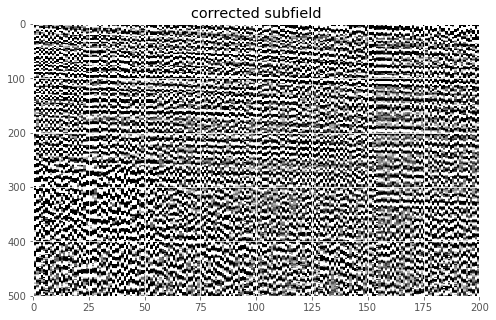

In [39]:
time = np.arange(200, 700)
correct_sub = time_dep(subsample, speed, time, 2., 1.)
cv = .1
seismic_plot(correct_sub, figsize=(8, 5), names='corrected subfield',
             vmin=-cv, vmax=cv, cmap='gray')

Для проверки качества работы алгоритма рисуется функция сглаженных значений амплитуды в зависимости от времени в децибелах.

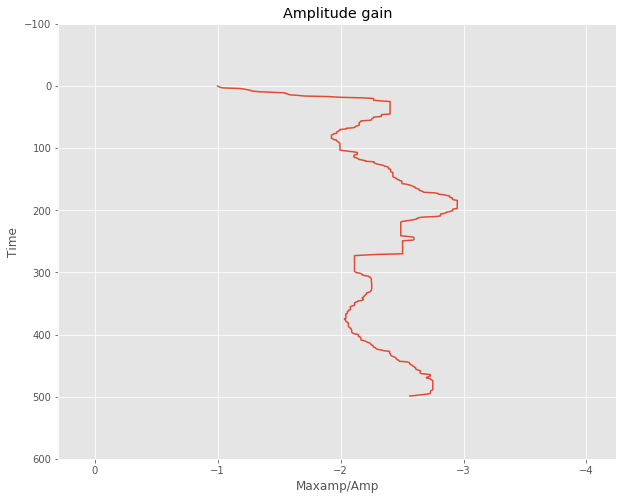

In [42]:
draw_gain(correct_sub, 51)

И для полного филда

(1000,)


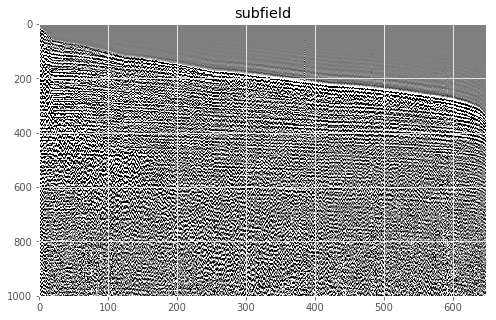

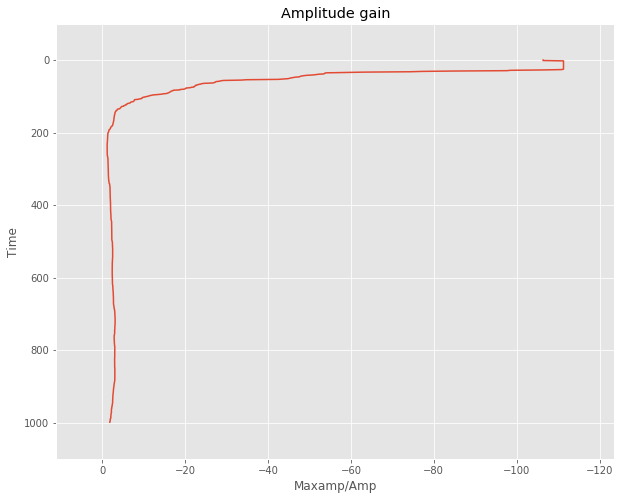

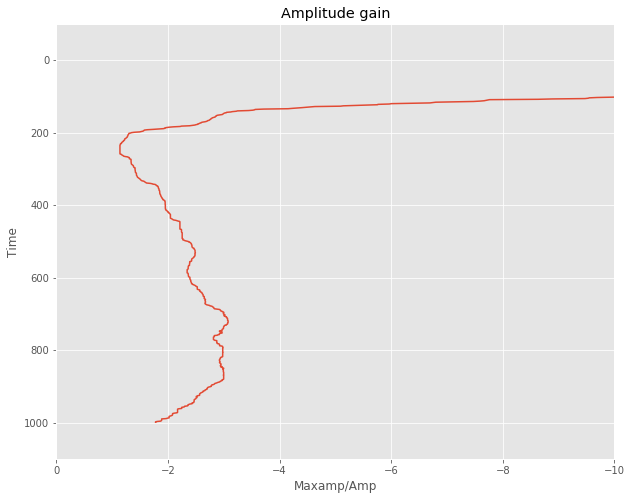

In [168]:
correct_field = time_dep(sample, speed, range(0, 1000), 2, 1)
cv = .1

seismic_plot(correct_field, figsize=(8, 5), names='subfield',
             vmin=-cv, vmax=cv, cmap='gray')
draw_gain(correct_field, 51)
draw_gain(correct_field, 51, (0, -10))

Видно, что и для кропа и для филда функция восстановления коррекции работает хорошо.

### Parameters estimation
Сейчас попробуем подобрать параметры $pow_t$ и $pow_v$ с помощью minimize из scipy. Параметром оптимизации будет медианное значение градиента первого порядка. Мы хотим чтобы оно стремилось к 0.

In [112]:
def calc_amp(parameters, field, speed, time):
    v_pow, t_pow = parameters
    new_field = time_dep(field, speed, time, v_pow, t_pow)
    h_sample = []
    for trace in new_field:
        hilb = hilbert(trace).real
        env = (trace**2 + hilb**2)**.5
        h_sample.append(env)
    h_sample = np.array(h_sample)
    mean_sample = np.mean(h_sample, axis=0)
    max_val = np.max(mean_sample)
    dt_val = (-1) * (max_val / mean_sample)
    result = medfilt(dt_val, 51)
    return np.median(np.abs(np.gradient(result)))

In [141]:
def find_optimal_parameters(fun, started_point, args, method):
    print('Starting search for optimal parameters...')
    f = minimize(fun, started_point, args=args, method=method)
    print('Minimization complited with following status: success = {}.'.format(f.success))
    print('Optimal parameters is: {} with value: {:.3}.'.format(f.x, f.get('fun')))
    return f.x

In [140]:
pow_v, pow_t = find_optimal_parameters(calc_amp, (2, 1), args=(sample, speed, time), method='Powell')

Minimization complited with following status: success = True
Optimal parameters is: [ 2.50731568 -1.1390687 ] with value: 0.00232.


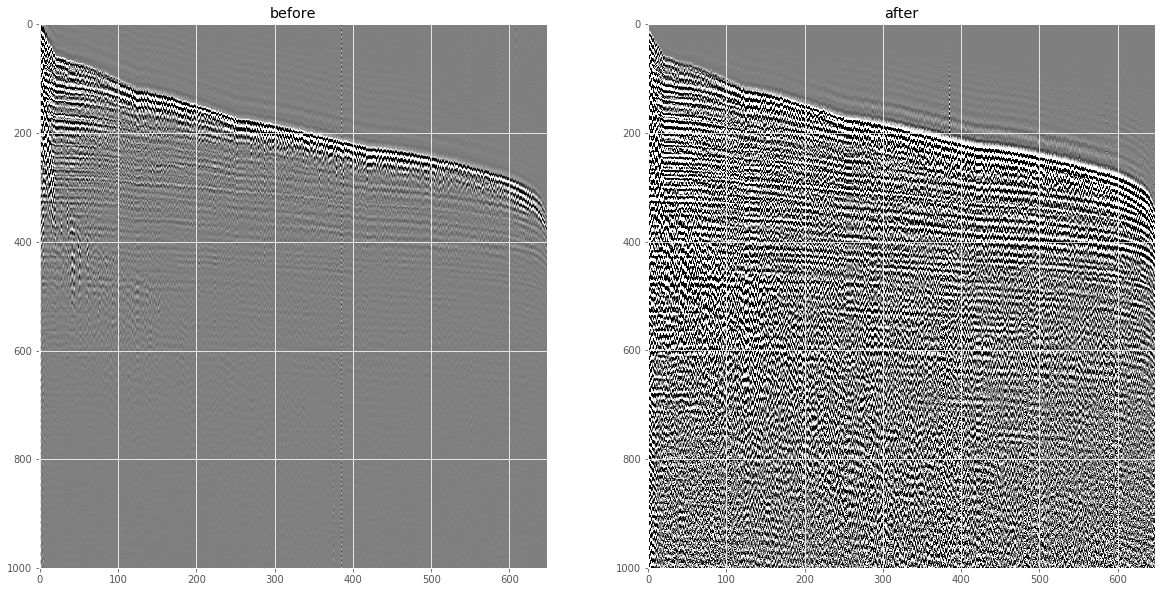

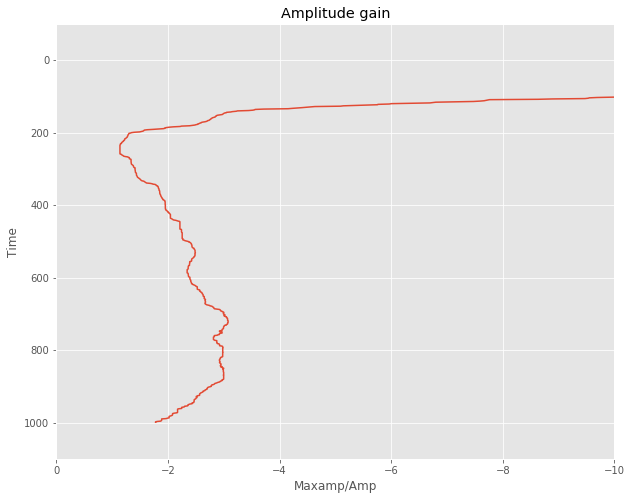

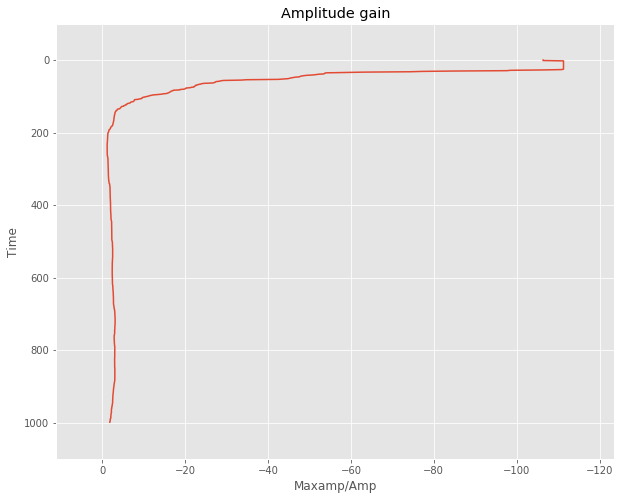

In [173]:
correct_field = time_dep(sample, speed, range(0, 1000), pow_v, pow_t)
cv = .1

seismic_plot([sample*10000, correct_field*200000], figsize=(20, 10), names=['before', 'after'],
             vmin=-cv, vmax=cv, cmap='gray')
draw_gain(correct_field, 51, (0, -10))
draw_gain(correct_field, 51)